In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")

C:\Users\admin\AppData\Local\Temp\ipykernel_11828\245186649.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261044,24.729267,23.821668,24.718171,212818400
2015-01-05,23.577579,24.110156,23.391179,24.030269,257142000
2015-01-06,23.579798,23.839428,23.218089,23.641931,263188400
2015-01-07,23.910437,24.010294,23.677434,23.788387,160423600
2015-01-08,24.829124,24.886821,24.121242,24.238854,237458000


In [5]:
data = df[['Close']].values

In [6]:
data[:10]

array([[24.26104355],
       [23.5775795 ],
       [23.57979774],
       [23.91043663],
       [24.82912445],
       [24.85575867],
       [24.24329376],
       [24.45853996],
       [24.365345  ],
       [23.70406532]])

In [7]:
train_size = int(len(data)*0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [8]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y) 

In [10]:
seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

In [11]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [12]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [13]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [14]:
model = GRUModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 20

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(Xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test).item()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(train_loader):.6f}, Val Loss: {val_loss:.6f}")


Epoch 1/20, Train Loss: 0.010301, Val Loss: 0.016288
Epoch 2/20, Train Loss: 0.148390, Val Loss: 0.247710
Epoch 3/20, Train Loss: 0.055825, Val Loss: 0.001539
Epoch 4/20, Train Loss: 0.028426, Val Loss: 0.073933
Epoch 5/20, Train Loss: 0.007327, Val Loss: 0.002515
Epoch 6/20, Train Loss: 0.008333, Val Loss: 0.005654
Epoch 7/20, Train Loss: 0.014659, Val Loss: 0.011904
Epoch 8/20, Train Loss: 0.012268, Val Loss: 0.001394
Epoch 9/20, Train Loss: 0.009039, Val Loss: 0.002555
Epoch 10/20, Train Loss: 0.008103, Val Loss: 0.001232
Epoch 11/20, Train Loss: 0.005796, Val Loss: 0.000947
Epoch 12/20, Train Loss: 0.005508, Val Loss: 0.001254
Epoch 13/20, Train Loss: 0.004553, Val Loss: 0.000839
Epoch 14/20, Train Loss: 0.004584, Val Loss: 0.001293
Epoch 15/20, Train Loss: 0.003945, Val Loss: 0.001018
Epoch 16/20, Train Loss: 0.003966, Val Loss: 0.001391
Epoch 17/20, Train Loss: 0.003662, Val Loss: 0.001219
Epoch 18/20, Train Loss: 0.003848, Val Loss: 0.001526
Epoch 19/20, Train Loss: 0.003575, Va

In [16]:
# model.load_state_dict(torch.load("best_model.pth"))

In [17]:
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

In [18]:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(y_test.numpy())

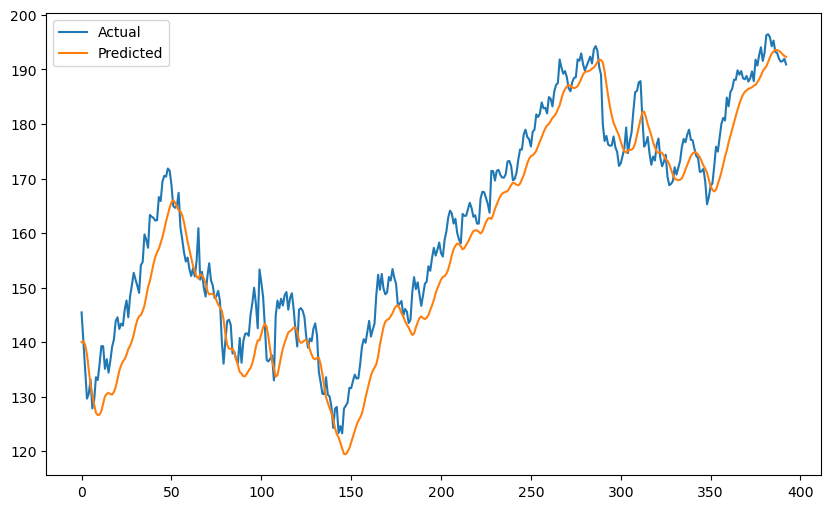

In [19]:
plt.figure(figsize=(10,6))
plt.plot(actual, label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.show()